In [5]:
library(dplyr);library(ggplot2);library(corrplot);library(matrixStats)
matchnew <- read.csv("match_newTeamID.csv", header=T)
tattnew <- read.csv("team_attributes_GrpByNewTEAMID.csv", header=T)
match2 <- matchnew%>%mutate(goalmargin = home_team_goal-away_team_goal)%>%
  mutate(outcome = ifelse(goalmargin==0, 0, goalmargin/abs(goalmargin)))
matchhome <- select(match2, seq(34,63,3))
matchdraw <- select(match2, seq(35,63,3))
matchaway <- select(match2, seq(36,63,3))
besthome <- transmute(matchhome, homeodds=rowMaxs(as.matrix(matchhome),na.rm=T))
bestdraw <- transmute(matchdraw, drawodds=rowMaxs(as.matrix(matchdraw),na.rm=T))
bestaway <- transmute(matchaway, awayodds=rowMaxs(as.matrix(matchaway),na.rm=T))
match2 <- bind_cols(match2,besthome,bestdraw,bestaway)
match2 <- match2%>%select(-seq(12,63),-c(1,2,'home_team_id','away_team_id','date','year'))%>%
  filter(homeodds>0)
summary(match2[,-c(1,3,4,7,8,9,10,11)])

       season     home_team_goal   away_team_goal    goalmargin     
 2015/2016:2906   Min.   : 0.000   Min.   :0.000   Min.   :-9.0000  
 2014/2015:2904   1st Qu.: 1.000   1st Qu.:0.000   1st Qu.:-1.0000  
 2008/2009:2898   Median : 1.000   Median :1.000   Median : 0.0000  
 2010/2011:2837   Mean   : 1.549   Mean   :1.166   Mean   : 0.3838  
 2012/2013:2832   3rd Qu.: 2.000   3rd Qu.:2.000   3rd Qu.: 1.0000  
 2011/2012:2814   Max.   :10.000   Max.   :9.000   Max.   :10.0000  
 (Other)  :5406                                                     
    outcome           homeodds         drawodds         awayodds     
 Min.   :-1.0000   Min.   : 1.030   Min.   : 1.330   Min.   : 1.100  
 1st Qu.:-1.0000   1st Qu.: 1.730   1st Qu.: 3.400   1st Qu.: 2.620  
 Median : 0.0000   Median : 2.200   Median : 3.600   Median : 3.700  
 Mean   : 0.1712   Mean   : 2.766   Mean   : 4.019   Mean   : 5.096  
 3rd Qu.: 1.0000   3rd Qu.: 2.900   3rd Qu.: 4.100   3rd Qu.: 5.500  
 Max.   : 1.0000   Max.   :3

In [6]:
# every match that dog wins
dogwins <- match2%>%filter(outcome==1 & homeodds>=3.5 | outcome==-1 & awayodds>=3.5)
summary(dogwins[,-c(1,3,4,7,8,9,10,11)])

       season    home_team_goal  away_team_goal   goalmargin     
 2015/2016:402   Min.   :0.000   Min.   :0.00   Min.   :-5.0000  
 2012/2013:378   1st Qu.:0.000   1st Qu.:1.00   1st Qu.:-2.0000  
 2014/2015:376   Median :1.000   Median :2.00   Median :-1.0000  
 2008/2009:373   Mean   :1.007   Mean   :1.73   Mean   :-0.7233  
 2010/2011:369   3rd Qu.:2.000   3rd Qu.:2.00   3rd Qu.: 1.0000  
 2011/2012:359   Max.   :6.000   Max.   :7.00   Max.   : 5.0000  
 (Other)  :656                                                   
    outcome           homeodds         drawodds        awayodds     
 Min.   :-1.0000   Min.   : 1.070   Min.   : 1.70   Min.   : 1.220  
 1st Qu.:-1.0000   1st Qu.: 1.800   1st Qu.: 3.40   1st Qu.: 2.300  
 Median :-1.0000   Median : 2.100   Median : 3.60   Median : 4.000  
 Mean   :-0.4775   Mean   : 2.743   Mean   : 3.82   Mean   : 4.494  
 3rd Qu.: 1.0000   3rd Qu.: 3.500   3rd Qu.: 4.00   3rd Qu.: 5.250  
 Max.   : 1.0000   Max.   :18.890   Max.   :12.00   Max.  

## visualise corr btw goalmargin and odds

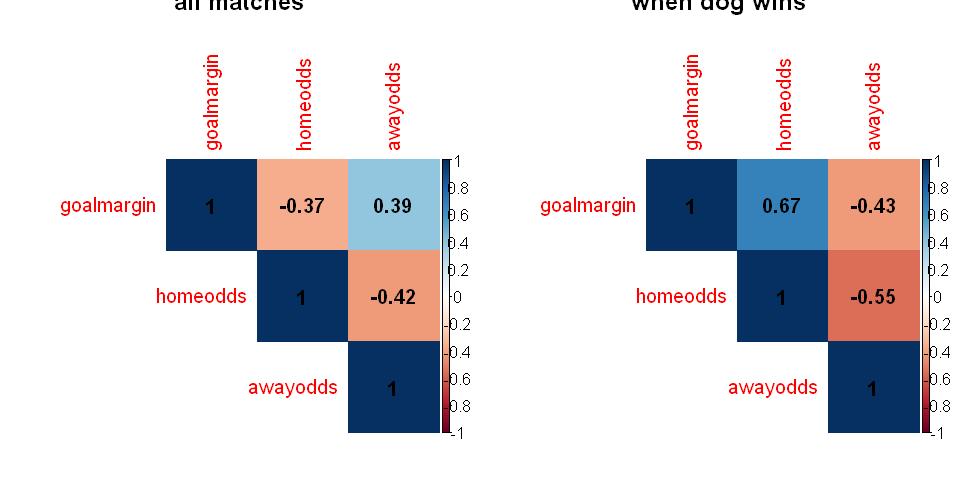

In [8]:
library(repr); options(repr.plot.width=8, repr.plot.height=4); par(mfrow=c(1,2))
corrplot(cor(match2[,c("goalmargin","homeodds","awayodds")]),type="upper",title="all matches",method="color",addCoef.col = "black",number.cex = 1)
corrplot(cor(dogwins[,c("goalmargin","homeodds","awayodds")]),type="upper",title="when dog wins",method="color",addCoef.col = "black",number.cex = 1)

## profit if bet ON dogs

In [10]:
homedogs <- match2%>%filter(homeodds>=3.5)%>%group_by(home_team_id_new)%>%summarise(homegames=n())
awaydogs <- match2%>%filter(awayodds>=3.5)%>%group_by(away_team_id_new)%>%summarise(awaygames=n())
homedata <- dogwins%>%filter(outcome==1)%>%group_by(home_team_id_new)%>%
  summarise(homewins=n(),homerevenue=sum(homeodds))%>%left_join(homedogs)%>%filter(!is.na(homewins))%>%
  mutate(homerev_multiple = homerevenue/homegames)%>%rename(dog=home_team_id_new)
awaydata <- dogwins%>%filter(outcome==-1)%>%group_by(away_team_id_new)%>%
  summarise(awaywins=n(),awayrevenue=sum(awayodds))%>%left_join(awaydogs)%>%filter(!is.na(awaywins))%>%
  mutate(awayrev_multiple = awayrevenue/awaygames)%>%rename(dog=away_team_id_new)
dogdata_new <- left_join(homedata,awaydata)
dogdata_new <- dogdata_new%>%filter(homegames>=3,awaygames>=3)
head(dogdata_new)
#write.csv(dogdata_new,'dogdata_new.csv',row.names=F)

Joining, by = "home_team_id_new"
Joining, by = "away_team_id_new"
Joining, by = "dog"


dog,homewins,homerevenue,homegames,homerev_multiple,awaywins,awayrevenue,awaygames,awayrev_multiple
17732011,2,13.00,4,3.250000,1,5.50,10,0.5500000
17732012,1,4.80,5,0.960000,2,8.18,15,0.5453333
20332014,1,5.91,5,1.182000,1,6.18,6,1.0300000
40492008,1,4.60,5,0.920000,1,4.20,8,0.5250000
40872012,1,3.50,5,0.700000,7,34.49,16,2.1556250
40872013,1,10.27,3,3.423333,2,12.76,14,0.9114286


homerev_multiple is how many times the return is over total bet amt, if bet that dog wins at home

## profit if bet AGAINST favourites

In [11]:
homefav <- match2%>%filter(awayodds>=3.5)%>%group_by(home_team_id_new)%>%summarise(homegames=n())
awayfav <- match2%>%filter(homeodds>=3.5)%>%group_by(away_team_id_new)%>%summarise(awaygames=n())
homedata1 <- match2%>%filter(awayodds>=3.5,outcome==-1)%>%group_by(home_team_id_new)%>%
  summarise(homelosses=n(),againsthomerevenue=sum(awayodds))%>%left_join(homefav)%>%filter(!is.na(homelosses))%>%
  mutate(againsthomerev_multiple = againsthomerevenue/homegames)%>%rename(fav=home_team_id_new)
awaydata1 <- match2%>%filter(homeodds>=3.5,outcome==1)%>%group_by(away_team_id_new)%>%
  summarise(awaylosses=n(),againstawayrevenue=sum(homeodds))%>%left_join(awayfav)%>%filter(!is.na(awaylosses))%>%
  mutate(againstawayrev_multiple = againstawayrevenue/awaygames)%>%rename(fav=away_team_id_new)
favdata_new <- left_join(homedata1,awaydata1)
favdata_new <- favdata_new%>%filter(homegames>=3,awaygames>=3)
head(favdata_new)
#write.csv(favdata_new,'favdata_new.csv',row.names=F)

Joining, by = "home_team_id_new"
Joining, by = "away_team_id_new"
Joining, by = "fav"


fav,homelosses,againsthomerevenue,homegames,againsthomerev_multiple,awaylosses,againstawayrevenue,awaygames,againstawayrev_multiple
80662015,2,8.69,12,0.7241667,2,9.60,6,1.6000000
81782008,2,9.75,8,1.2187500,1,5.25,5,1.0500000
81782009,3,17.25,14,1.2321429,1,3.50,6,0.5833333
81782010,2,12.90,15,0.8600000,1,5.40,5,1.0800000
81782011,3,19.80,14,1.4142857,3,11.93,9,1.3255556
81782013,1,7.50,15,0.5000000,2,11.75,8,1.4687500


againsthomerev_multiple is how many times the return is over total bet amt, if bet against the fav (bet that fav loses at home)

## identify feasible gooddogs and badfavs w multiple>1 (profit positive)

In [12]:
goodhomedogs <- dogdata_new%>%filter(homerev_multiple>1)
goodawaydogs <- dogdata_new%>%filter(awayrev_multiple>1)
badhomefavs <- favdata_new%>%filter(againsthomerev_multiple>1)
badawayfavs <- favdata_new%>%filter(againstawayrev_multiple>1)
head(arrange(goodhomedogs,desc(homerev_multiple)))
head(arrange(goodawaydogs,desc(awayrev_multiple)))
head(arrange(badhomefavs,desc(againsthomerev_multiple)))
head(arrange(badawayfavs,desc(againstawayrev_multiple)))

dog,homewins,homerevenue,homegames,homerev_multiple,awaywins,awayrevenue,awaygames,awayrev_multiple
99042011,3,18.90,3,6.300000,1,3.75,8,0.4687500
98102010,3,16.75,4,4.187500,3,13.80,9,1.5333333
98762016,2,12.40,3,4.133333,1,4.58,11,0.4163636
84672016,2,12.09,3,4.030000,1,4.86,4,1.2150000
85402011,3,11.30,3,3.766667,2,16.00,14,1.1428571
99272013,2,11.20,3,3.733333,1,4.34,3,1.4466667


dog,homewins,homerevenue,homegames,homerev_multiple,awaywins,awayrevenue,awaygames,awayrev_multiple
102782010,1,3.50,3,1.166667,1,34.00,8,4.250000
98262015,2,9.29,7,1.327143,5,32.78,10,3.278000
85972012,1,3.93,3,1.310000,4,34.89,11,3.171818
85832009,1,3.80,4,0.950000,7,47.50,15,3.166667
78442009,1,3.75,6,0.625000,1,8.50,3,2.833333
101942014,3,17.20,6,2.866667,5,39.64,14,2.831429


fav,homelosses,againsthomerevenue,homegames,againsthomerev_multiple,awaylosses,againstawayrevenue,awaygames,againstawayrev_multiple
97732016,2,55.57,8,6.946250,3,23.74,9,2.637778
98252008,2,28.00,8,3.500000,3,18.50,8,2.312500
97612008,2,14.00,5,2.800000,1,3.65,3,1.216667
99912012,6,38.34,14,2.738571,2,9.25,6,1.541667
86502012,6,44.65,17,2.626471,6,27.21,13,2.093077
97732008,1,15.00,6,2.500000,1,6.00,4,1.500000


fav,homelosses,againsthomerevenue,homegames,againsthomerev_multiple,awaylosses,againstawayrevenue,awaygames,againstawayrev_multiple
102292013,3,18.60,11,1.690909,3,15.47,4,3.867500
99062014,1,6.31,16,0.394375,4,43.47,15,2.898000
97892014,4,37.97,16,2.373125,7,42.24,15,2.816000
97732016,2,55.57,8,6.946250,3,23.74,9,2.637778
85922015,5,38.54,17,2.267059,5,20.56,8,2.570000
84662015,3,18.33,14,1.309286,4,14.88,6,2.480000


## analyse conditions of dog winning
league,stage,season,date

### leaguescore

In [13]:
byleagueplayed <- match2%>%group_by(league_id)%>%summarise(games=n())
byleaguewin <- match2%>%filter(outcome!=0, ifelse(outcome==1,homeodds>3.5,awayodds>3.5))%>%
  group_by(league_id)%>%summarise(dogwins=n())%>%left_join(byleagueplayed)%>%
  mutate(leaguescore = dogwins/games)
head(byleaguewin)
#write.csv(byleaguewin,'byleaguewin.csv',row.names=F)

Joining, by = "league_id"


league_id,dogwins,games,leaguescore
1,196,1706,0.1148886
1729,403,3040,0.1325658
4769,387,3037,0.1274284
7809,322,2447,0.1315897
10257,368,3014,0.1220969
13274,278,2445,0.1137014


### stagescore

In [14]:
bystage <- match2%>%group_by(stage)%>%summarise(games=n())
bystagewin <- match2%>%filter(outcome!=0, ifelse(outcome==1,homeodds>3.5,awayodds>3.5))%>%
  group_by(stage)%>%summarise(dogwins=n())%>%left_join(bystage)%>%
  mutate(stagescore = dogwins/games)
head(bystagewin)
#write.csv(bystagewin,'bystagewin.csv',row.names=F)

Joining, by = "stage"


stage,dogwins,games,stagescore
1,79,633,0.1248025
2,82,633,0.1295419
3,65,633,0.1026856
4,81,634,0.1277603
5,78,631,0.1236133
6,77,634,0.1214511


### seasonscore

In [16]:
byseason <- match2%>%group_by(season)%>%summarise(games=n())
byseasonwin <- match2%>%filter(outcome!=0, ifelse(outcome==1,homeodds>3.5,awayodds>3.5))%>%
  group_by(season)%>%summarise(dogwins=n())%>%left_join(byseason)%>%
  mutate(seasonscore = dogwins/games)
head(byseasonwin)
#write.csv(byseasonwin,'byseasonwin.csv',row.names=F)

Joining, by = "season"


season,dogwins,games,seasonscore
2008/2009,339,2898,0.1169772
2009/2010,310,2807,0.1104382
2010/2011,345,2837,0.1216073
2011/2012,330,2814,0.1172708
2012/2013,365,2832,0.1288842
2013/2014,318,2599,0.1223548


### weekscore

In [17]:
byweek <- match2%>%group_by(week_num)%>%summarise(games=n())
byweekwin <- match2%>%filter(outcome!=0, ifelse(outcome==1,homeodds>3.5,awayodds>3.5))%>%
  group_by(week_num)%>%summarise(dogwins=n())%>%left_join(byweek)%>%filter(games>(mean(games)-sd(games)))%>%
  mutate(weekscore = dogwins/games)
head(byweekwin)
#write.csv(byweekwin,'byweekwin.csv',row.names=F)

Joining, by = "week_num"


week_num,dogwins,games,weekscore
1,41,330,0.12424242
2,57,498,0.11445783
3,57,575,0.09913043
4,61,548,0.11131387
5,86,730,0.11780822
6,86,648,0.13271605


### visualise conditions with mean ref line

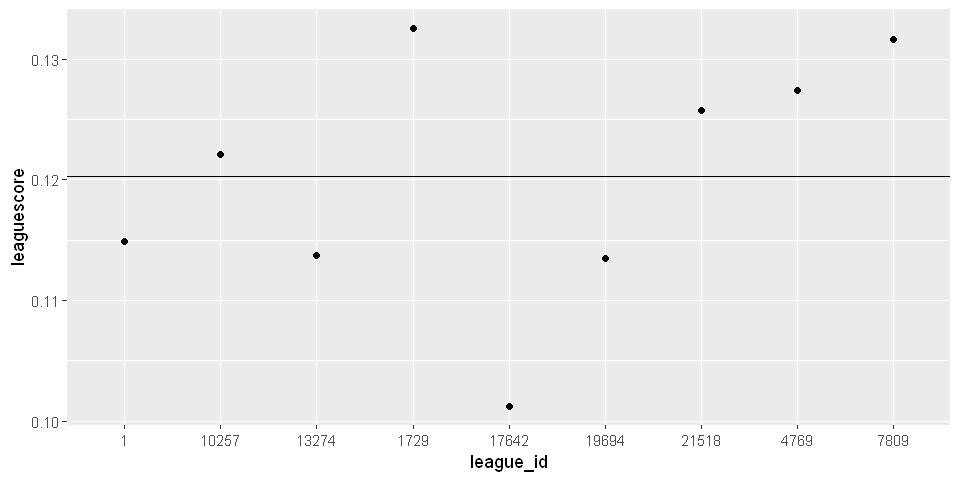

In [18]:
byleaguewin[1] <- sapply(byleaguewin[1], as.character)
ggplot(byleaguewin, aes(league_id, leaguescore)) +geom_point()+geom_hline(aes(yintercept =(mean(leaguescore))))

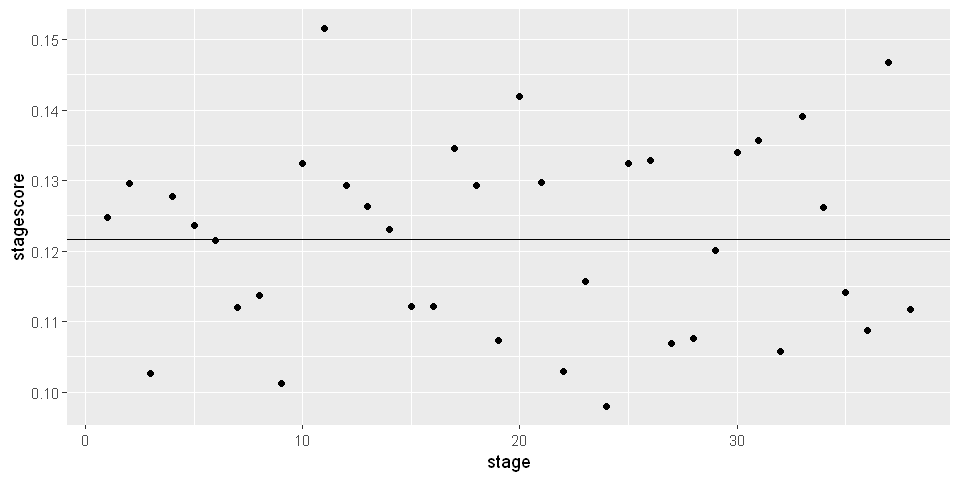

In [19]:
ggplot(bystagewin, aes(stage, stagescore)) +geom_point()+geom_hline(aes(yintercept =(mean(stagescore))))

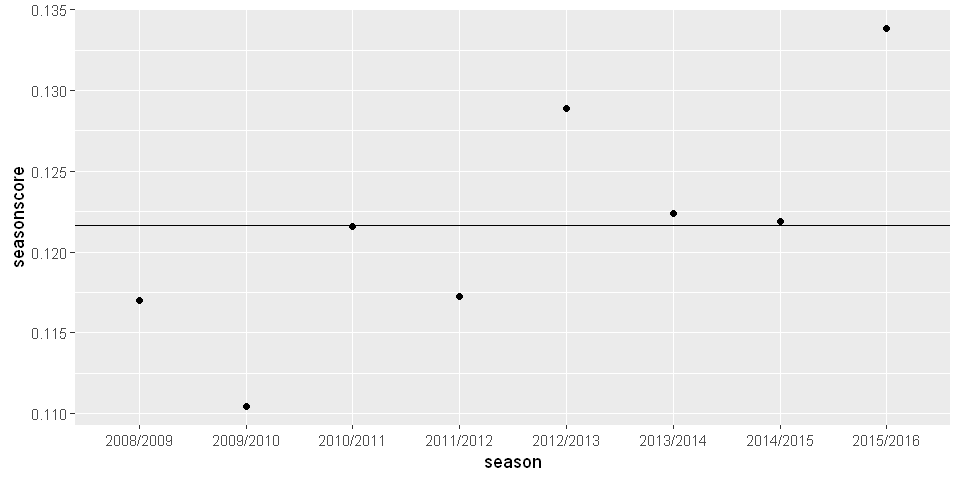

In [22]:
ggplot(byseasonwin, aes(season, seasonscore)) +geom_point()+geom_hline(aes(yintercept =(mean(seasonscore))))

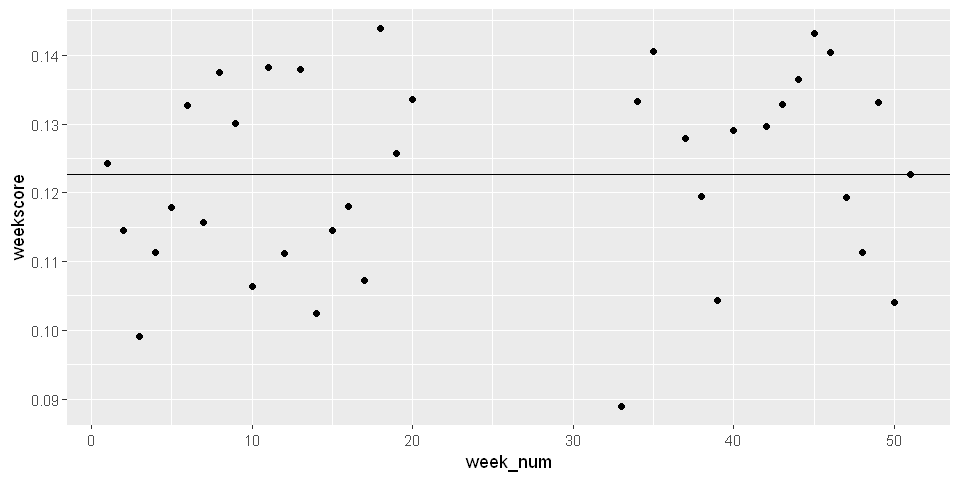

In [23]:
ggplot(byweekwin, aes(week_num, weekscore)) +geom_point()+geom_hline(aes(yintercept =(mean(weekscore))))